# Sign Detection 


In [30]:
# Initialization
%load_ext autoreload
%autoreload 2
import sys
import os
import copy

# To be able to reference packages/modules in this repository, this
# relative path must be added to the python path. Your notebook may be 
# in a different folder, so modify this variable to point to the src 
# folder.
src_rel_path = './'
proj_src_root = os.path.abspath(src_rel_path)
proj_root_path = os.path.abspath(src_rel_path + "../")

data_path = "/home/default/workspace/cs6945share/blyncsy_signs/tdot/images"
data_path2 = "/home/default/workspace/cs6945share/blyncsy_signs/udot/images"
if proj_src_root not in sys.path:
    sys.path.insert(0, proj_src_root)
    print("Updated Python Path")

print(f"Project Root Path: {proj_root_path}")
print(f"Project Source Root Path: {proj_src_root}")
print(f"Project Data Path: {data_path}")
# print(f"Project Data Path 2: {data_path}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project Root Path: /cs6945share/sign_project/SignDetection
Project Source Root Path: /cs6945share/sign_project/SignDetection/DetectionTraining
Project Data Path: /home/default/workspace/cs6945share/blyncsy_signs/tdot/images


## Library Imports

In [31]:
# Basic imports for file manipulation
import time
import copy
import numpy as np
import pandas as pd
from glob import glob

# Pytorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# torchvision imports
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F

# Some locally defined libraries (see the "train" folder)
import train.transforms as transforms
import train.coco_utils2 as coco_utils
import train.utils
import train.engine2 as engine

from torchvision.datasets.kitti import Kitti
# OpenCV computer vision library for image manipulation
import cv2 as cv 

# The following are to do with interactive notebook code
%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import matplotlib.patches as patches
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

print(f"OpenCV Version: {cv.__version__}")
plt.ion()   # interactive mode

OpenCV Version: 4.2.0


# Dataset Transformation Definitions
In this cell the dataset tranformations are defined:
- "train": applies to images before they are fed to the training process
- "val": applies to images before the are fed to the evaluation process
- "view": applies to images before they are displayed

In [32]:
# Data augmentation and normalization for training
# pretrained models expect certain size and normalization
# https://pytorch.org/vision/stable/models.html

# training_images_path =  os.path.join(data_path, "barrels/train/images")
training_images_path = data_path
# training_images_path2 = data_path2
test_images_path = data_path
# test_images_path = "/home/default/workspace/cs6945share/blyncsy_signs/tdotandudot/images"

anns_file = os.path.join(proj_src_root, "sign_tdot_v4.json")
# anns_file2 = os.path.join(proj_src_root, "instances_default_edits.json")

data_transforms = {
    'train': transforms.Compose([
        coco_utils.ConvertCocoPolysToMask(),
        transforms.RandomHorizontalFlip(),
        
        # New Transformations
        # transforms.RandomPhotometricDistort(contrast = (0.9, 1.1), saturation = (0.9, 1.1),
        #          hue = (-0.025, 0.025), brightness = (0.9, 1.1)),
        # transforms.RandomIoUCrop(min_aspect_ratio=1.2, max_aspect_ratio=2.5),
        # transforms.RandomZoomOut(side_range=(1,1.5), p=0.25),
        
    
        transforms.ToTensor(),
        # Normalization numbers are from here: https://pytorch.org/vision/stable/models.html
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        coco_utils.ConvertCocoPolysToMask(),
        transforms.ToTensor(),
        # Normalization numbers are from here: https://pytorch.org/vision/stable/models.html
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'view': transforms.Compose([
        coco_utils.ConvertCocoPolysToMask(),
        transforms.ToTensor(),
    ]),
}

# Dataset Exploration
The following cells provide some example code for understanding the data

The annotated data is provided in a format that follow the [COCO Dataset](https://cocodataset.org/#home). A python library called pycocotools provides functions for manipulating this data, and some further utility functions have been provided in the coco_utils.py file in the train folder. These are modified functions from the torch vision [library](https://github.com/pytorch/vision/blob/main/references/detection/coco_utils.py). Often, to accelerate development we adopt open-source libraries, however, as you'll find these libraries are not always documented well.

In [33]:
# Load the dataset into memory and print it's length

task_dataset = coco_utils.CocoDetection(training_images_path,
                                      anns_file,
                                      data_transforms['val']
                                      )

# task_dataset2 = coco_utils.CocoDetection(training_images_path2,
#                                       anns_file2,
#                                       data_transforms['val']
#                                       )

dataset_size = len(task_dataset)
# dataset_size2 = len(task_dataset2)
print("image_dataset length (tdot):\t" + str(dataset_size))
# print("image_dataset2 length (udot):\t" + str(dataset_size2))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
image_dataset length (tdot):	620


## Preview an Image
The python coco library has some peculiar processes, so here's an example of loading a displaying a single image. Notice that opencv uses BGR color ordering, which differs from the stored format. 

Not all the images in this dataset came with annotations - they may have been skipped by the annotator. Notice the code that selects only the images that have an associated annotation. This variable will be re-used later when the dataset is split up for training and evaluation

Opening file: /home/default/workspace/cs6945share/blyncsy_signs/tdot/images/12.6.18.3.4.jpg


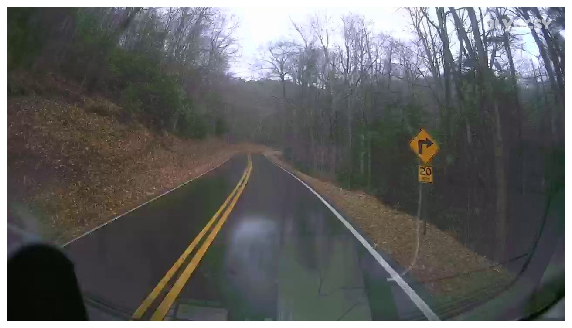

In [5]:
class_names = task_dataset.coco.getAnnIds()
anns = task_dataset.coco.loadAnns(class_names)
images_w_anns_ids = [ann['image_id'] for ann in anns]
images_w_anns_ids = np.unique(np.array(images_w_anns_ids))
imgs = task_dataset.coco.loadImgs(images_w_anns_ids)

# class_names2 = task_dataset2.coco.getAnnIds()
# anns2 = task_dataset2.coco.loadAnns(class_names2)
# images_w_anns_ids2 = [ann['image_id'] for ann in anns2]
# images_w_anns_ids2 = np.unique(np.array(images_w_anns_ids2))
# imgs2 = task_dataset2.coco.loadImgs(images_w_anns_ids2)

# previewing the data
im1 = imgs[1]
im_file = training_images_path + "/" + im1['file_name']
print("Opening file: " + im_file)
im = cv.imread(im_file)
im_bgr = cv.cvtColor(im, cv.COLOR_RGB2BGR)
plt.axis('off')
plt.imshow(im_bgr)
plt.show()

## Preview an Annotation
The following code shows how you can display the annotations associated with an image

In [6]:
annIds = task_dataset.coco.getAnnIds(imgIds=im1['id'])
anns = task_dataset.coco.loadAnns(annIds)
print(anns)

[{'id': 324, 'image_id': 12, 'category_id': 1, 'bbox': [918, 276, 76, 87], 'score': 0.0, 'area': 6612, 'dimensions': [0.0, 0.0, 0.0], 'rotation_y': 0.0, 'occluded': 0, 'truncated': 0.0, 'location': [0.0, 0.0, 0.0], 'iscrowd': 0.0}, {'id': 325, 'image_id': 12, 'category_id': 1, 'bbox': [940, 362, 38, 45], 'score': 0.0, 'area': 1710, 'dimensions': [0.0, 0.0, 0.0], 'rotation_y': 0.0, 'occluded': 0, 'truncated': 0.0, 'location': [0.0, 0.0, 0.0], 'iscrowd': 0.0}]


# Pre-Trained Model Selection and Modification
The following code shows how to load a pretrained model from the [torchvision library](https://pytorch.org/vision/master/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html), then replace layers to adapt to the new dataset.

In [35]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
    # and replace the mask predictor with a new one
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                        hidden_layer,
#                                                        num_classes)

    return model

# Load the Pretrained Model
This cell executes the downloading and modification of the pretrained model, then sets up the optimizer for training

In [36]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: " + str(device))
# our dataset has two classes only - background and sign
num_classes = 2
lr = 0.0001

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
# opt = 'SGD'
opt = 'Adam'
if opt == 'SGD':
    optimizer = torch.optim.SGD(params, lr=lr,
                                momentum=0.9, weight_decay=0.0005)
    # optimizer = torch.optim.SGD(params, lr=lr)
    
    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_sched = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.2)
elif opt == 'Adam':
    optimizer = torch.optim.Adam(params, lr=lr)
    lr_sched = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.2)
else:
    ValueError('opt must be ''Adam'' or ''SGD.''')



Using device: cuda


# Split Dataset for Training and Evaluation
The following code shows how to split the dataset into training and evaluation subsets. Notice how each subset incorporates the transformations defined earlier.

In [20]:
dataset = coco_utils.CocoDetection(training_images_path, anns_file, data_transforms['train'])
# dataset2 = coco_utils.CocoDetection(training_images_path2, anns_file2, data_transforms['train'])

dataset_val = coco_utils.CocoDetection(training_images_path, anns_file, data_transforms['val'])
dataset_test = coco_utils.CocoDetection(training_images_path, anns_file, data_transforms['val'])

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
# indices = torch.randperm(len(concat_dataset)).tolist()
num_indices = len(indices)
val_ratio = 15./100
# test_ratio = 1./10
print(f"Dataset with consists of {num_indices} images")

val_split = np.round(val_ratio*num_indices).astype(int)
test_split = -20
print(f"Splitting dataset at index (one-based) {val_split}")
print(f"Splitting dataset at index (one-based) {test_split}")
val_inds = indices[:val_split]
train_inds = indices[val_split:test_split]
test_inds = indices[test_split:]
print(f"Training set has {len(train_inds)} images")
print(f"Validation set has {len(val_inds)} images")
print(f"Test set has {len(test_inds)} images")

dataset = torch.utils.data.Subset(dataset, train_inds)
dataset_val = torch.utils.data.Subset(dataset_val, val_inds)
dataset_test = torch.utils.data.Subset(dataset_test, test_inds)

batch_size = 4

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=8,
                                         collate_fn=train.utils.collate_fn)

# dataloader = torch.utils.data.DataLoader(dataset_combined,
#                                          batch_size=batch_size,
#                                          shuffle=True,
#                                          num_workers=8,
#                                          collate_fn=train.utils.collate_fn)


dataloader_val = torch.utils.data.DataLoader(dataset_val,
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=8,
                                              collate_fn=train.utils.collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Dataset with consists of 620 images
Splitting dataset at index (one-based) 93
Splitting dataset at index (one-based) -20
Training set has 507 images
Validation set has 93 images
Test set has 20 images


# Train!

In [21]:
# Select the number of epochs to train
num_epochs = 30

loss_logs = []
res_logs = []

best_acc = 0

model_name = model.__class__.__name__
desc = "frcnn_sceds3gamma2_run3"
model_root = os.path.join(proj_src_root, "models/")
lr_str = str(lr).replace('.', 'pt')

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metric_logger = engine.train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq=10)
    # update the learning rate
#     if opt == 'SGD':
    lr_sched.step()
   
    # evaluate on the test dataset
    res = engine.evaluate(model, dataloader_val, device=device)

    loss_logs.append(metric_logger)
    res_logs.append(res)
    
    types = res.iou_types
    stats = res.coco_eval[types[0]].stats
    acc = stats[0]
    if acc > best_acc:
        best_acc = acc
        
        inf_model_name = f"{model_name}_{desc}_signs_{opt}_{lr_str}_{num_epochs}epochs_bs{batch_size}_state.pth"
        torch.save(model.state_dict(), model_root + inf_model_name)
        
# load best model weights 


Epoch: [0]  [  0/127]  eta: 0:03:13  lr: 0.000001  loss: 1.7683 (1.7683)  loss_classifier: 1.1597 (1.1597)  loss_box_reg: 0.0284 (0.0284)  loss_objectness: 0.4631 (0.4631)  loss_rpn_box_reg: 0.1170 (0.1170)  time: 1.5257  data: 0.8236  max mem: 4509
Epoch: [0]  [ 10/127]  eta: 0:01:02  lr: 0.000009  loss: 1.2928 (1.2143)  loss_classifier: 0.8325 (0.7823)  loss_box_reg: 0.0198 (0.0247)  loss_objectness: 0.2707 (0.3480)  loss_rpn_box_reg: 0.0435 (0.0593)  time: 0.5332  data: 0.0894  max mem: 4511
Epoch: [0]  [ 20/127]  eta: 0:00:55  lr: 0.000017  loss: 0.6232 (0.8553)  loss_classifier: 0.2634 (0.4854)  loss_box_reg: 0.0312 (0.0387)  loss_objectness: 0.2266 (0.2755)  loss_rpn_box_reg: 0.0321 (0.0557)  time: 0.4670  data: 0.0134  max mem: 4511
Epoch: [0]  [ 30/127]  eta: 0:00:49  lr: 0.000025  loss: 0.4099 (0.7086)  loss_classifier: 0.1208 (0.3686)  loss_box_reg: 0.0610 (0.0487)  loss_objectness: 0.1267 (0.2371)  loss_rpn_box_reg: 0.0323 (0.0542)  time: 0.4918  data: 0.0121  max mem: 4511


Epoch: [1]  [ 80/127]  eta: 0:00:21  lr: 0.000100  loss: 0.3005 (0.2719)  loss_classifier: 0.0944 (0.0859)  loss_box_reg: 0.1393 (0.1265)  loss_objectness: 0.0261 (0.0326)  loss_rpn_box_reg: 0.0201 (0.0269)  time: 0.4711  data: 0.0123  max mem: 4511
Epoch: [1]  [ 90/127]  eta: 0:00:16  lr: 0.000100  loss: 0.2607 (0.2722)  loss_classifier: 0.0747 (0.0855)  loss_box_reg: 0.1211 (0.1257)  loss_objectness: 0.0195 (0.0341)  loss_rpn_box_reg: 0.0172 (0.0269)  time: 0.4303  data: 0.0118  max mem: 4511
Epoch: [1]  [100/127]  eta: 0:00:12  lr: 0.000100  loss: 0.2789 (0.2760)  loss_classifier: 0.0849 (0.0863)  loss_box_reg: 0.1036 (0.1248)  loss_objectness: 0.0394 (0.0368)  loss_rpn_box_reg: 0.0199 (0.0281)  time: 0.4437  data: 0.0115  max mem: 4511
Epoch: [1]  [110/127]  eta: 0:00:07  lr: 0.000100  loss: 0.2516 (0.2782)  loss_classifier: 0.0760 (0.0866)  loss_box_reg: 0.1036 (0.1249)  loss_objectness: 0.0412 (0.0373)  loss_rpn_box_reg: 0.0263 (0.0294)  time: 0.4401  data: 0.0110  max mem: 4511


Test:  [27/93]  eta: 0:00:03  model_time: 0.0245 (0.0252)  evaluator_time: 0.0019 (0.0027)  time: 0.0329  data: 0.0038  max mem: 4511
Test:  [36/93]  eta: 0:00:02  model_time: 0.0251 (0.0253)  evaluator_time: 0.0021 (0.0028)  time: 0.0341  data: 0.0044  max mem: 4511
Test:  [45/93]  eta: 0:00:02  model_time: 0.0251 (0.0252)  evaluator_time: 0.0020 (0.0027)  time: 0.0335  data: 0.0042  max mem: 4511
Test:  [54/93]  eta: 0:00:01  model_time: 0.0248 (0.0252)  evaluator_time: 0.0021 (0.0027)  time: 0.0331  data: 0.0040  max mem: 4511
Test:  [63/93]  eta: 0:00:01  model_time: 0.0246 (0.0251)  evaluator_time: 0.0022 (0.0027)  time: 0.0328  data: 0.0039  max mem: 4511
Test:  [72/93]  eta: 0:00:00  model_time: 0.0245 (0.0250)  evaluator_time: 0.0022 (0.0027)  time: 0.0327  data: 0.0039  max mem: 4511
Test:  [81/93]  eta: 0:00:00  model_time: 0.0245 (0.0250)  evaluator_time: 0.0018 (0.0026)  time: 0.0323  data: 0.0039  max mem: 4511
Test:  [90/93]  eta: 0:00:00  model_time: 0.0245 (0.0250)  eva

Epoch: [4]  [  0/127]  eta: 0:04:03  lr: 0.000020  loss: 0.1065 (0.1065)  loss_classifier: 0.0355 (0.0355)  loss_box_reg: 0.0650 (0.0650)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0055 (0.0055)  time: 1.9136  data: 0.7992  max mem: 4511
Epoch: [4]  [ 10/127]  eta: 0:01:10  lr: 0.000020  loss: 0.1847 (0.1803)  loss_classifier: 0.0496 (0.0490)  loss_box_reg: 0.1030 (0.1043)  loss_objectness: 0.0051 (0.0073)  loss_rpn_box_reg: 0.0176 (0.0197)  time: 0.6055  data: 0.0861  max mem: 4511
Epoch: [4]  [ 20/127]  eta: 0:01:02  lr: 0.000020  loss: 0.1550 (0.1738)  loss_classifier: 0.0483 (0.0478)  loss_box_reg: 0.0912 (0.1014)  loss_objectness: 0.0051 (0.0071)  loss_rpn_box_reg: 0.0079 (0.0175)  time: 0.5174  data: 0.0128  max mem: 4511
Epoch: [4]  [ 30/127]  eta: 0:00:50  lr: 0.000020  loss: 0.1396 (0.1678)  loss_classifier: 0.0372 (0.0466)  loss_box_reg: 0.0844 (0.0995)  loss_objectness: 0.0026 (0.0063)  loss_rpn_box_reg: 0.0060 (0.0154)  time: 0.4700  data: 0.0117  max mem: 4511


Epoch: [5]  [ 80/127]  eta: 0:00:22  lr: 0.000020  loss: 0.1445 (0.1574)  loss_classifier: 0.0395 (0.0421)  loss_box_reg: 0.0896 (0.0963)  loss_objectness: 0.0034 (0.0046)  loss_rpn_box_reg: 0.0059 (0.0144)  time: 0.5083  data: 0.0117  max mem: 4511
Epoch: [5]  [ 90/127]  eta: 0:00:18  lr: 0.000020  loss: 0.1320 (0.1581)  loss_classifier: 0.0352 (0.0421)  loss_box_reg: 0.0891 (0.0968)  loss_objectness: 0.0030 (0.0046)  loss_rpn_box_reg: 0.0059 (0.0147)  time: 0.5102  data: 0.0116  max mem: 4511
Epoch: [5]  [100/127]  eta: 0:00:13  lr: 0.000020  loss: 0.1617 (0.1598)  loss_classifier: 0.0421 (0.0428)  loss_box_reg: 0.0993 (0.0977)  loss_objectness: 0.0027 (0.0045)  loss_rpn_box_reg: 0.0118 (0.0147)  time: 0.4704  data: 0.0113  max mem: 4511
Epoch: [5]  [110/127]  eta: 0:00:08  lr: 0.000020  loss: 0.1522 (0.1611)  loss_classifier: 0.0438 (0.0433)  loss_box_reg: 0.0940 (0.0987)  loss_objectness: 0.0036 (0.0045)  loss_rpn_box_reg: 0.0118 (0.0146)  time: 0.4801  data: 0.0110  max mem: 4511


Test:  [27/93]  eta: 0:00:03  model_time: 0.0248 (0.0253)  evaluator_time: 0.0015 (0.0022)  time: 0.0329  data: 0.0039  max mem: 4511
Test:  [36/93]  eta: 0:00:03  model_time: 0.0248 (0.0252)  evaluator_time: 0.0015 (0.0022)  time: 0.0332  data: 0.0043  max mem: 4511
Test:  [45/93]  eta: 0:00:02  model_time: 0.0247 (0.0252)  evaluator_time: 0.0015 (0.0020)  time: 0.0329  data: 0.0043  max mem: 4511
Test:  [54/93]  eta: 0:00:01  model_time: 0.0247 (0.0251)  evaluator_time: 0.0017 (0.0021)  time: 0.0332  data: 0.0043  max mem: 4511
Test:  [63/93]  eta: 0:00:01  model_time: 0.0247 (0.0251)  evaluator_time: 0.0019 (0.0021)  time: 0.0334  data: 0.0042  max mem: 4511
Test:  [72/93]  eta: 0:00:00  model_time: 0.0247 (0.0250)  evaluator_time: 0.0018 (0.0021)  time: 0.0330  data: 0.0042  max mem: 4511
Test:  [81/93]  eta: 0:00:00  model_time: 0.0248 (0.0250)  evaluator_time: 0.0017 (0.0021)  time: 0.0331  data: 0.0043  max mem: 4511
Test:  [90/93]  eta: 0:00:00  model_time: 0.0249 (0.0251)  eva

Epoch: [8]  [  0/127]  eta: 0:03:21  lr: 0.000004  loss: 0.0601 (0.0601)  loss_classifier: 0.0189 (0.0189)  loss_box_reg: 0.0365 (0.0365)  loss_objectness: 0.0034 (0.0034)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 1.5876  data: 0.8222  max mem: 4511
Epoch: [8]  [ 10/127]  eta: 0:01:07  lr: 0.000004  loss: 0.1198 (0.1155)  loss_classifier: 0.0323 (0.0336)  loss_box_reg: 0.0693 (0.0710)  loss_objectness: 0.0021 (0.0022)  loss_rpn_box_reg: 0.0052 (0.0086)  time: 0.5793  data: 0.0866  max mem: 4511
Epoch: [8]  [ 20/127]  eta: 0:00:50  lr: 0.000004  loss: 0.1230 (0.1236)  loss_classifier: 0.0323 (0.0340)  loss_box_reg: 0.0752 (0.0777)  loss_objectness: 0.0021 (0.0023)  loss_rpn_box_reg: 0.0052 (0.0096)  time: 0.4185  data: 0.0120  max mem: 4511
Epoch: [8]  [ 30/127]  eta: 0:00:45  lr: 0.000004  loss: 0.1388 (0.1337)  loss_classifier: 0.0318 (0.0354)  loss_box_reg: 0.0828 (0.0850)  loss_objectness: 0.0016 (0.0020)  loss_rpn_box_reg: 0.0078 (0.0113)  time: 0.4011  data: 0.0122  max mem: 4511


Epoch: [9]  [ 80/127]  eta: 0:00:21  lr: 0.000001  loss: 0.1391 (0.1365)  loss_classifier: 0.0361 (0.0358)  loss_box_reg: 0.0957 (0.0840)  loss_objectness: 0.0012 (0.0030)  loss_rpn_box_reg: 0.0091 (0.0137)  time: 0.4602  data: 0.0129  max mem: 4511
Epoch: [9]  [ 90/127]  eta: 0:00:17  lr: 0.000001  loss: 0.1391 (0.1381)  loss_classifier: 0.0372 (0.0363)  loss_box_reg: 0.0926 (0.0846)  loss_objectness: 0.0019 (0.0030)  loss_rpn_box_reg: 0.0140 (0.0142)  time: 0.4800  data: 0.0122  max mem: 4511
Epoch: [9]  [100/127]  eta: 0:00:12  lr: 0.000001  loss: 0.1196 (0.1361)  loss_classifier: 0.0343 (0.0360)  loss_box_reg: 0.0741 (0.0839)  loss_objectness: 0.0014 (0.0029)  loss_rpn_box_reg: 0.0057 (0.0134)  time: 0.4091  data: 0.0127  max mem: 4511
Epoch: [9]  [110/127]  eta: 0:00:07  lr: 0.000001  loss: 0.0934 (0.1340)  loss_classifier: 0.0249 (0.0355)  loss_box_reg: 0.0612 (0.0830)  loss_objectness: 0.0012 (0.0028)  loss_rpn_box_reg: 0.0047 (0.0127)  time: 0.3887  data: 0.0137  max mem: 4511


Test:  [27/93]  eta: 0:00:03  model_time: 0.0247 (0.0253)  evaluator_time: 0.0015 (0.0020)  time: 0.0325  data: 0.0039  max mem: 4511
Test:  [36/93]  eta: 0:00:02  model_time: 0.0247 (0.0252)  evaluator_time: 0.0015 (0.0020)  time: 0.0321  data: 0.0038  max mem: 4511
Test:  [45/93]  eta: 0:00:02  model_time: 0.0246 (0.0251)  evaluator_time: 0.0015 (0.0019)  time: 0.0318  data: 0.0038  max mem: 4511
Test:  [54/93]  eta: 0:00:01  model_time: 0.0247 (0.0250)  evaluator_time: 0.0015 (0.0019)  time: 0.0320  data: 0.0039  max mem: 4511
Test:  [63/93]  eta: 0:00:01  model_time: 0.0246 (0.0249)  evaluator_time: 0.0017 (0.0019)  time: 0.0320  data: 0.0038  max mem: 4511
Test:  [72/93]  eta: 0:00:00  model_time: 0.0246 (0.0250)  evaluator_time: 0.0016 (0.0019)  time: 0.0325  data: 0.0039  max mem: 4511
Test:  [81/93]  eta: 0:00:00  model_time: 0.0251 (0.0251)  evaluator_time: 0.0016 (0.0019)  time: 0.0338  data: 0.0044  max mem: 4511
Test:  [90/93]  eta: 0:00:00  model_time: 0.0252 (0.0251)  eva

Epoch: [12]  [  0/127]  eta: 0:03:08  lr: 0.000000  loss: 0.1475 (0.1475)  loss_classifier: 0.0393 (0.0393)  loss_box_reg: 0.0972 (0.0972)  loss_objectness: 0.0028 (0.0028)  loss_rpn_box_reg: 0.0083 (0.0083)  time: 1.4850  data: 0.8152  max mem: 4511
Epoch: [12]  [ 10/127]  eta: 0:00:53  lr: 0.000000  loss: 0.0999 (0.1373)  loss_classifier: 0.0307 (0.0372)  loss_box_reg: 0.0691 (0.0835)  loss_objectness: 0.0028 (0.0050)  loss_rpn_box_reg: 0.0065 (0.0116)  time: 0.4589  data: 0.0901  max mem: 4511
Epoch: [12]  [ 20/127]  eta: 0:00:50  lr: 0.000000  loss: 0.1093 (0.1361)  loss_classifier: 0.0303 (0.0365)  loss_box_reg: 0.0731 (0.0859)  loss_objectness: 0.0018 (0.0036)  loss_rpn_box_reg: 0.0060 (0.0101)  time: 0.4180  data: 0.0137  max mem: 4511
Epoch: [12]  [ 30/127]  eta: 0:00:42  lr: 0.000000  loss: 0.1195 (0.1346)  loss_classifier: 0.0328 (0.0355)  loss_box_reg: 0.0789 (0.0861)  loss_objectness: 0.0017 (0.0032)  loss_rpn_box_reg: 0.0072 (0.0099)  time: 0.4286  data: 0.0115  max mem: 4

Epoch: [13]  [ 80/127]  eta: 0:00:20  lr: 0.000000  loss: 0.1454 (0.1393)  loss_classifier: 0.0411 (0.0371)  loss_box_reg: 0.0961 (0.0864)  loss_objectness: 0.0016 (0.0028)  loss_rpn_box_reg: 0.0101 (0.0129)  time: 0.4269  data: 0.0121  max mem: 4511
Epoch: [13]  [ 90/127]  eta: 0:00:15  lr: 0.000000  loss: 0.1237 (0.1362)  loss_classifier: 0.0367 (0.0364)  loss_box_reg: 0.0828 (0.0849)  loss_objectness: 0.0011 (0.0027)  loss_rpn_box_reg: 0.0058 (0.0123)  time: 0.4213  data: 0.0124  max mem: 4511
Epoch: [13]  [100/127]  eta: 0:00:11  lr: 0.000000  loss: 0.1204 (0.1347)  loss_classifier: 0.0294 (0.0360)  loss_box_reg: 0.0746 (0.0840)  loss_objectness: 0.0010 (0.0026)  loss_rpn_box_reg: 0.0053 (0.0122)  time: 0.4326  data: 0.0122  max mem: 4511
Epoch: [13]  [110/127]  eta: 0:00:07  lr: 0.000000  loss: 0.1166 (0.1339)  loss_classifier: 0.0287 (0.0355)  loss_box_reg: 0.0739 (0.0835)  loss_objectness: 0.0013 (0.0027)  loss_rpn_box_reg: 0.0071 (0.0123)  time: 0.4398  data: 0.0126  max mem: 4

Test:  [27/93]  eta: 0:00:03  model_time: 0.0248 (0.0255)  evaluator_time: 0.0014 (0.0020)  time: 0.0330  data: 0.0040  max mem: 4511
Test:  [36/93]  eta: 0:00:03  model_time: 0.0248 (0.0254)  evaluator_time: 0.0014 (0.0019)  time: 0.0329  data: 0.0040  max mem: 4511
Test:  [45/93]  eta: 0:00:02  model_time: 0.0247 (0.0253)  evaluator_time: 0.0014 (0.0018)  time: 0.0325  data: 0.0040  max mem: 4511
Test:  [54/93]  eta: 0:00:01  model_time: 0.0246 (0.0252)  evaluator_time: 0.0017 (0.0019)  time: 0.0328  data: 0.0042  max mem: 4511
Test:  [63/93]  eta: 0:00:01  model_time: 0.0248 (0.0252)  evaluator_time: 0.0019 (0.0019)  time: 0.0335  data: 0.0043  max mem: 4511
Test:  [72/93]  eta: 0:00:00  model_time: 0.0248 (0.0253)  evaluator_time: 0.0020 (0.0020)  time: 0.0338  data: 0.0042  max mem: 4511
Test:  [81/93]  eta: 0:00:00  model_time: 0.0247 (0.0252)  evaluator_time: 0.0019 (0.0020)  time: 0.0332  data: 0.0040  max mem: 4511
Test:  [90/93]  eta: 0:00:00  model_time: 0.0246 (0.0252)  eva

Epoch: [16]  [  0/127]  eta: 0:04:08  lr: 0.000000  loss: 0.1960 (0.1960)  loss_classifier: 0.0477 (0.0477)  loss_box_reg: 0.1360 (0.1360)  loss_objectness: 0.0021 (0.0021)  loss_rpn_box_reg: 0.0102 (0.0102)  time: 1.9586  data: 0.8441  max mem: 4511
Epoch: [16]  [ 10/127]  eta: 0:01:09  lr: 0.000000  loss: 0.1283 (0.1340)  loss_classifier: 0.0289 (0.0341)  loss_box_reg: 0.0840 (0.0873)  loss_objectness: 0.0010 (0.0015)  loss_rpn_box_reg: 0.0093 (0.0111)  time: 0.5921  data: 0.0908  max mem: 4511
Epoch: [16]  [ 20/127]  eta: 0:00:56  lr: 0.000000  loss: 0.1032 (0.1224)  loss_classifier: 0.0284 (0.0321)  loss_box_reg: 0.0676 (0.0781)  loss_objectness: 0.0008 (0.0020)  loss_rpn_box_reg: 0.0083 (0.0103)  time: 0.4575  data: 0.0120  max mem: 4511
Epoch: [16]  [ 30/127]  eta: 0:00:46  lr: 0.000000  loss: 0.1144 (0.1297)  loss_classifier: 0.0308 (0.0345)  loss_box_reg: 0.0680 (0.0800)  loss_objectness: 0.0026 (0.0029)  loss_rpn_box_reg: 0.0070 (0.0123)  time: 0.4187  data: 0.0114  max mem: 4

Epoch: [17]  [ 80/127]  eta: 0:00:20  lr: 0.000000  loss: 0.0988 (0.1318)  loss_classifier: 0.0268 (0.0351)  loss_box_reg: 0.0620 (0.0819)  loss_objectness: 0.0007 (0.0026)  loss_rpn_box_reg: 0.0056 (0.0122)  time: 0.4313  data: 0.0139  max mem: 4511
Epoch: [17]  [ 90/127]  eta: 0:00:16  lr: 0.000000  loss: 0.0988 (0.1301)  loss_classifier: 0.0259 (0.0344)  loss_box_reg: 0.0620 (0.0807)  loss_objectness: 0.0016 (0.0027)  loss_rpn_box_reg: 0.0061 (0.0123)  time: 0.4700  data: 0.0149  max mem: 4511
Epoch: [17]  [100/127]  eta: 0:00:11  lr: 0.000000  loss: 0.1256 (0.1305)  loss_classifier: 0.0279 (0.0347)  loss_box_reg: 0.0662 (0.0805)  loss_objectness: 0.0022 (0.0027)  loss_rpn_box_reg: 0.0108 (0.0127)  time: 0.4400  data: 0.0139  max mem: 4511
Epoch: [17]  [110/127]  eta: 0:00:07  lr: 0.000000  loss: 0.1256 (0.1293)  loss_classifier: 0.0344 (0.0346)  loss_box_reg: 0.0676 (0.0798)  loss_objectness: 0.0014 (0.0026)  loss_rpn_box_reg: 0.0085 (0.0122)  time: 0.4343  data: 0.0134  max mem: 4

Test:  [27/93]  eta: 0:00:03  model_time: 0.0248 (0.0251)  evaluator_time: 0.0015 (0.0021)  time: 0.0327  data: 0.0037  max mem: 4511
Test:  [36/93]  eta: 0:00:02  model_time: 0.0248 (0.0249)  evaluator_time: 0.0015 (0.0020)  time: 0.0324  data: 0.0040  max mem: 4511
Test:  [45/93]  eta: 0:00:02  model_time: 0.0245 (0.0249)  evaluator_time: 0.0015 (0.0019)  time: 0.0321  data: 0.0041  max mem: 4511
Test:  [54/93]  eta: 0:00:01  model_time: 0.0245 (0.0248)  evaluator_time: 0.0016 (0.0020)  time: 0.0322  data: 0.0040  max mem: 4511
Test:  [63/93]  eta: 0:00:01  model_time: 0.0246 (0.0249)  evaluator_time: 0.0017 (0.0019)  time: 0.0327  data: 0.0041  max mem: 4511
Test:  [72/93]  eta: 0:00:00  model_time: 0.0247 (0.0249)  evaluator_time: 0.0018 (0.0019)  time: 0.0329  data: 0.0042  max mem: 4511
Test:  [81/93]  eta: 0:00:00  model_time: 0.0247 (0.0248)  evaluator_time: 0.0016 (0.0019)  time: 0.0325  data: 0.0041  max mem: 4511
Test:  [90/93]  eta: 0:00:00  model_time: 0.0246 (0.0248)  eva

Epoch: [20]  [  0/127]  eta: 0:03:29  lr: 0.000000  loss: 0.0590 (0.0590)  loss_classifier: 0.0167 (0.0167)  loss_box_reg: 0.0402 (0.0402)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 1.6460  data: 0.8529  max mem: 4511
Epoch: [20]  [ 10/127]  eta: 0:01:00  lr: 0.000000  loss: 0.0974 (0.1044)  loss_classifier: 0.0284 (0.0277)  loss_box_reg: 0.0638 (0.0669)  loss_objectness: 0.0007 (0.0016)  loss_rpn_box_reg: 0.0056 (0.0082)  time: 0.5148  data: 0.0907  max mem: 4511
Epoch: [20]  [ 20/127]  eta: 0:00:49  lr: 0.000000  loss: 0.1075 (0.1230)  loss_classifier: 0.0299 (0.0329)  loss_box_reg: 0.0757 (0.0777)  loss_objectness: 0.0010 (0.0026)  loss_rpn_box_reg: 0.0075 (0.0098)  time: 0.4010  data: 0.0124  max mem: 4511
Epoch: [20]  [ 30/127]  eta: 0:00:45  lr: 0.000000  loss: 0.1356 (0.1276)  loss_classifier: 0.0360 (0.0342)  loss_box_reg: 0.0884 (0.0790)  loss_objectness: 0.0019 (0.0026)  loss_rpn_box_reg: 0.0097 (0.0118)  time: 0.4411  data: 0.0124  max mem: 4

Epoch: [21]  [ 80/127]  eta: 0:00:20  lr: 0.000000  loss: 0.1281 (0.1319)  loss_classifier: 0.0304 (0.0346)  loss_box_reg: 0.0781 (0.0819)  loss_objectness: 0.0005 (0.0026)  loss_rpn_box_reg: 0.0073 (0.0128)  time: 0.4103  data: 0.0142  max mem: 4511
Epoch: [21]  [ 90/127]  eta: 0:00:16  lr: 0.000000  loss: 0.1281 (0.1297)  loss_classifier: 0.0293 (0.0342)  loss_box_reg: 0.0781 (0.0802)  loss_objectness: 0.0019 (0.0027)  loss_rpn_box_reg: 0.0097 (0.0125)  time: 0.4013  data: 0.0143  max mem: 4511
Epoch: [21]  [100/127]  eta: 0:00:11  lr: 0.000000  loss: 0.1223 (0.1315)  loss_classifier: 0.0326 (0.0346)  loss_box_reg: 0.0818 (0.0819)  loss_objectness: 0.0019 (0.0027)  loss_rpn_box_reg: 0.0092 (0.0124)  time: 0.4389  data: 0.0138  max mem: 4511
Epoch: [21]  [110/127]  eta: 0:00:07  lr: 0.000000  loss: 0.1223 (0.1298)  loss_classifier: 0.0326 (0.0342)  loss_box_reg: 0.0844 (0.0810)  loss_objectness: 0.0010 (0.0026)  loss_rpn_box_reg: 0.0075 (0.0120)  time: 0.4589  data: 0.0138  max mem: 4

Test:  [27/93]  eta: 0:00:04  model_time: 0.0253 (0.0267)  evaluator_time: 0.0017 (0.0040)  time: 0.0375  data: 0.0041  max mem: 4511
Test:  [36/93]  eta: 0:00:03  model_time: 0.0258 (0.0267)  evaluator_time: 0.0018 (0.0036)  time: 0.0386  data: 0.0044  max mem: 4511
Test:  [45/93]  eta: 0:00:02  model_time: 0.0254 (0.0264)  evaluator_time: 0.0018 (0.0032)  time: 0.0352  data: 0.0047  max mem: 4511
Test:  [54/93]  eta: 0:00:01  model_time: 0.0251 (0.0262)  evaluator_time: 0.0017 (0.0031)  time: 0.0340  data: 0.0046  max mem: 4511
Test:  [63/93]  eta: 0:00:01  model_time: 0.0249 (0.0260)  evaluator_time: 0.0018 (0.0029)  time: 0.0338  data: 0.0046  max mem: 4511
Test:  [72/93]  eta: 0:00:00  model_time: 0.0247 (0.0259)  evaluator_time: 0.0018 (0.0028)  time: 0.0337  data: 0.0046  max mem: 4511
Test:  [81/93]  eta: 0:00:00  model_time: 0.0249 (0.0260)  evaluator_time: 0.0017 (0.0027)  time: 0.0347  data: 0.0047  max mem: 4511
Test:  [90/93]  eta: 0:00:00  model_time: 0.0251 (0.0259)  eva

Epoch: [24]  [  0/127]  eta: 0:05:14  lr: 0.000000  loss: 0.1294 (0.1294)  loss_classifier: 0.0288 (0.0288)  loss_box_reg: 0.0779 (0.0779)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0210 (0.0210)  time: 2.4765  data: 0.8697  max mem: 4511
Epoch: [24]  [ 10/127]  eta: 0:01:10  lr: 0.000000  loss: 0.1294 (0.1210)  loss_classifier: 0.0290 (0.0330)  loss_box_reg: 0.0779 (0.0748)  loss_objectness: 0.0022 (0.0023)  loss_rpn_box_reg: 0.0074 (0.0109)  time: 0.6017  data: 0.0919  max mem: 4511
Epoch: [24]  [ 20/127]  eta: 0:00:54  lr: 0.000000  loss: 0.1353 (0.1346)  loss_classifier: 0.0366 (0.0367)  loss_box_reg: 0.0815 (0.0827)  loss_objectness: 0.0018 (0.0021)  loss_rpn_box_reg: 0.0076 (0.0131)  time: 0.4076  data: 0.0128  max mem: 4511
Epoch: [24]  [ 30/127]  eta: 0:00:45  lr: 0.000000  loss: 0.1353 (0.1301)  loss_classifier: 0.0366 (0.0367)  loss_box_reg: 0.0815 (0.0799)  loss_objectness: 0.0017 (0.0021)  loss_rpn_box_reg: 0.0079 (0.0114)  time: 0.4001  data: 0.0130  max mem: 4

Epoch: [25]  [ 80/127]  eta: 0:00:21  lr: 0.000000  loss: 0.1177 (0.1303)  loss_classifier: 0.0329 (0.0346)  loss_box_reg: 0.0733 (0.0804)  loss_objectness: 0.0011 (0.0028)  loss_rpn_box_reg: 0.0080 (0.0126)  time: 0.4091  data: 0.0138  max mem: 4511
Epoch: [25]  [ 90/127]  eta: 0:00:17  lr: 0.000000  loss: 0.1306 (0.1326)  loss_classifier: 0.0394 (0.0351)  loss_box_reg: 0.0823 (0.0820)  loss_objectness: 0.0011 (0.0027)  loss_rpn_box_reg: 0.0111 (0.0128)  time: 0.4108  data: 0.0139  max mem: 4511
Epoch: [25]  [100/127]  eta: 0:00:12  lr: 0.000000  loss: 0.1456 (0.1335)  loss_classifier: 0.0413 (0.0355)  loss_box_reg: 0.0843 (0.0824)  loss_objectness: 0.0014 (0.0027)  loss_rpn_box_reg: 0.0127 (0.0129)  time: 0.4491  data: 0.0136  max mem: 4511
Epoch: [25]  [110/127]  eta: 0:00:07  lr: 0.000000  loss: 0.1347 (0.1339)  loss_classifier: 0.0379 (0.0358)  loss_box_reg: 0.0821 (0.0829)  loss_objectness: 0.0014 (0.0026)  loss_rpn_box_reg: 0.0082 (0.0127)  time: 0.4410  data: 0.0137  max mem: 4

Test:  [27/93]  eta: 0:00:03  model_time: 0.0248 (0.0251)  evaluator_time: 0.0014 (0.0020)  time: 0.0337  data: 0.0047  max mem: 4511
Test:  [36/93]  eta: 0:00:03  model_time: 0.0247 (0.0250)  evaluator_time: 0.0015 (0.0019)  time: 0.0331  data: 0.0043  max mem: 4511
Test:  [45/93]  eta: 0:00:02  model_time: 0.0247 (0.0250)  evaluator_time: 0.0015 (0.0018)  time: 0.0328  data: 0.0043  max mem: 4511
Test:  [54/93]  eta: 0:00:01  model_time: 0.0247 (0.0250)  evaluator_time: 0.0016 (0.0019)  time: 0.0334  data: 0.0046  max mem: 4511
Test:  [63/93]  eta: 0:00:01  model_time: 0.0247 (0.0249)  evaluator_time: 0.0018 (0.0019)  time: 0.0338  data: 0.0047  max mem: 4511
Test:  [72/93]  eta: 0:00:00  model_time: 0.0246 (0.0249)  evaluator_time: 0.0018 (0.0019)  time: 0.0332  data: 0.0044  max mem: 4511
Test:  [81/93]  eta: 0:00:00  model_time: 0.0246 (0.0249)  evaluator_time: 0.0016 (0.0019)  time: 0.0332  data: 0.0043  max mem: 4511
Test:  [90/93]  eta: 0:00:00  model_time: 0.0246 (0.0249)  eva

Epoch: [28]  [  0/127]  eta: 0:02:58  lr: 0.000000  loss: 0.1428 (0.1428)  loss_classifier: 0.0482 (0.0482)  loss_box_reg: 0.0889 (0.0889)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 1.4052  data: 0.8831  max mem: 4511
Epoch: [28]  [ 10/127]  eta: 0:00:56  lr: 0.000000  loss: 0.1188 (0.1212)  loss_classifier: 0.0312 (0.0327)  loss_box_reg: 0.0807 (0.0754)  loss_objectness: 0.0009 (0.0014)  loss_rpn_box_reg: 0.0056 (0.0118)  time: 0.4849  data: 0.0938  max mem: 4511
Epoch: [28]  [ 20/127]  eta: 0:00:51  lr: 0.000000  loss: 0.0848 (0.1112)  loss_classifier: 0.0267 (0.0302)  loss_box_reg: 0.0565 (0.0688)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0053 (0.0108)  time: 0.4374  data: 0.0125  max mem: 4511
Epoch: [28]  [ 30/127]  eta: 0:00:47  lr: 0.000000  loss: 0.0848 (0.1106)  loss_classifier: 0.0254 (0.0308)  loss_box_reg: 0.0565 (0.0680)  loss_objectness: 0.0008 (0.0021)  loss_rpn_box_reg: 0.0044 (0.0097)  time: 0.5000  data: 0.0117  max mem: 4

Epoch: [29]  [ 80/127]  eta: 0:00:19  lr: 0.000000  loss: 0.0875 (0.1279)  loss_classifier: 0.0291 (0.0340)  loss_box_reg: 0.0558 (0.0796)  loss_objectness: 0.0010 (0.0022)  loss_rpn_box_reg: 0.0040 (0.0121)  time: 0.3975  data: 0.0126  max mem: 4511
Epoch: [29]  [ 90/127]  eta: 0:00:15  lr: 0.000000  loss: 0.1280 (0.1283)  loss_classifier: 0.0347 (0.0344)  loss_box_reg: 0.0802 (0.0800)  loss_objectness: 0.0012 (0.0023)  loss_rpn_box_reg: 0.0056 (0.0116)  time: 0.4305  data: 0.0133  max mem: 4511
Epoch: [29]  [100/127]  eta: 0:00:11  lr: 0.000000  loss: 0.1354 (0.1296)  loss_classifier: 0.0359 (0.0345)  loss_box_reg: 0.0871 (0.0809)  loss_objectness: 0.0020 (0.0024)  loss_rpn_box_reg: 0.0083 (0.0117)  time: 0.4496  data: 0.0131  max mem: 4511
Epoch: [29]  [110/127]  eta: 0:00:07  lr: 0.000000  loss: 0.1354 (0.1307)  loss_classifier: 0.0360 (0.0348)  loss_box_reg: 0.0851 (0.0816)  loss_objectness: 0.0020 (0.0024)  loss_rpn_box_reg: 0.0089 (0.0119)  time: 0.4093  data: 0.0129  max mem: 4

In [22]:
model.load_state_dict(torch.load(model_root + inf_model_name))

<All keys matched successfully>

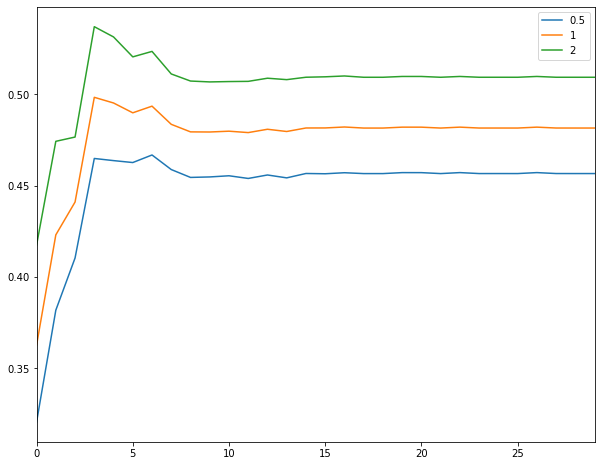

In [23]:
def Fstat(prec_recall, beta):
    prec, recall = prec_recall[0], prec_recall[1]
    F = (1 + beta**2)*(prec*recall/(beta**2*prec + recall))
    return F

def save_unique_df(df, name):
    if os.path.exists(name):
        files = glob(name[:-6] + '*')
        nums = [str(name[-6:-4]) for names in files]
        next_num = max(nums) + 1
        new_name = files[0][:-4] + str(next_num).zfill(2) + '.csv'
        df.to_csv(new_name)
    else:
        df.to_csv(name[:-4] + '00' + '.csv')

betas = [0.5, 1, 2]
for epoch in range(num_epochs):
    res_log = res_logs[epoch]
    types = res_log.iou_types
    stats = res_log.coco_eval[types[0]].stats
    prec_recall = np.array([stats[0], stats[8]])
    Fs = [Fstat(prec_recall, beta) for beta in betas]
    if epoch == 0:
        F_array = Fs
        thick_stats = stats
    else:
        F_array = np.vstack((F_array, Fs))
        thick_stats = np.vstack((thick_stats, stats))
        
evaldf = pd.DataFrame(F_array, columns=['0.5', '1', '2'])
evaldf.plot()

thick_cols = ["AP_all 0.5:0.95", "AP_all 0.5", "AP_all 0.75", "AP_small", "AP_medium", "AP_large",
              "AR_all dets1", "AR_all dets10", "AR_all 0.5:0.95", "AR_small", "AR_medium", "AR_large"]
thickdf = pd.DataFrame(thick_stats, columns=thick_cols)

lr_str = str(lr).replace('.', 'pt')
fname = f'{model_name}_{desc}_{opt}_lr' + lr_str + f'_bs{batch_size}_notransforms2' + '_RESULT.csv'
os.makedirs(os.path.join(proj_src_root + '/train/losses'), exist_ok=True)

save_unique_df(evaldf, proj_src_root + '/train/losses/' + fname)

fname2 = f'{model_name}_{desc}_{opt}_lr' + lr_str + f'_bs{batch_size}_notransforms2' + '_thick.csv'
save_unique_df(thickdf, proj_src_root + '/train/losses/' + fname2)
# evaldf.to_csv(proj_src_root + '/train/losses/' + fname)

In [25]:
# getting the loss info from the training
epoch_meters = list(loss_logs[0].meters.items())
attrs = [epoch_meters[i][0] for i in range(len(epoch_meters))]

for epoch in range(num_epochs):
    vals = np.array([loss_logs[epoch].__getattr__(attr).global_avg for attr in attrs])
    if epoch == 0:
        log_array = vals
    else:
        log_array = np.vstack((log_array, vals))
lossdf = pd.DataFrame(log_array, columns = attrs)
lossdf.head()

lr      loss  loss_classifier  loss_box_reg  loss_objectness  \
0  0.000051  0.445980         0.169527      0.102599         0.131579   
1  0.000100  0.274583         0.084930      0.124224         0.037148   
2  0.000100  0.231494         0.072810      0.120660         0.015407   
3  0.000020  0.193289         0.056663      0.109773         0.008167   
4  0.000020  0.172079         0.047353      0.102874         0.005361   

   loss_rpn_box_reg  
0          0.042275  
1          0.028281  
2          0.022617  
3          0.018686  
4          0.016491

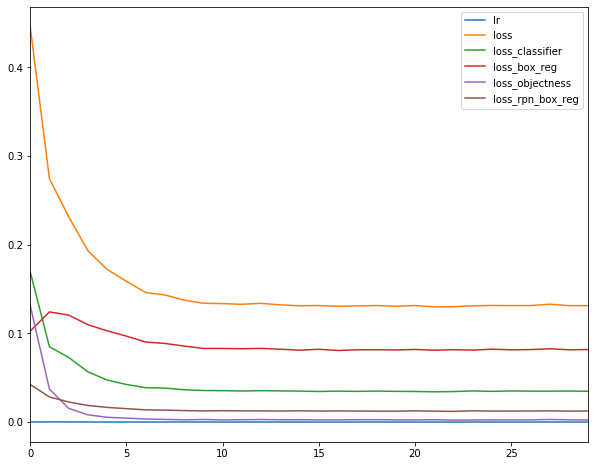

In [26]:
lossdf.plot()
lr_str = str(lr).replace('.', 'pt')
fname = f'{model_name}_{desc}_{opt}_lr' + lr_str + f'_bs{batch_size}_notransforms2.csv'
os.makedirs(os.path.join(proj_src_root + '/train/losses'), exist_ok=True)

save_unique_df(lossdf, proj_src_root + '/train/losses/' + fname)
# lossdf.to_csv(proj_src_root + '/train/losses/' + fname)

In [27]:
# A Helper function for displaying images
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Sample Evaluation
The following cell shows how to run predictions on images using the model

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Showing images from range(155, 165)


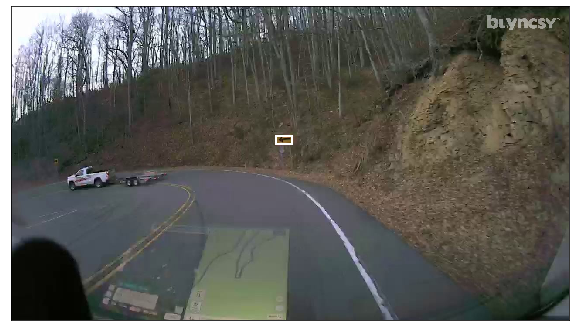

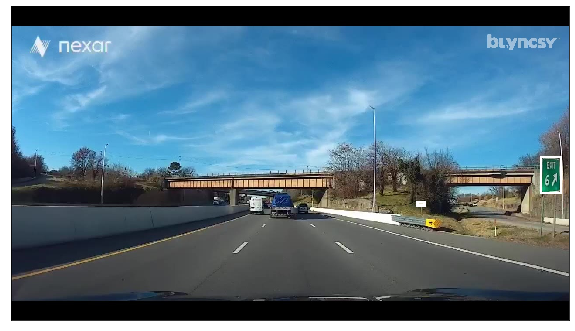

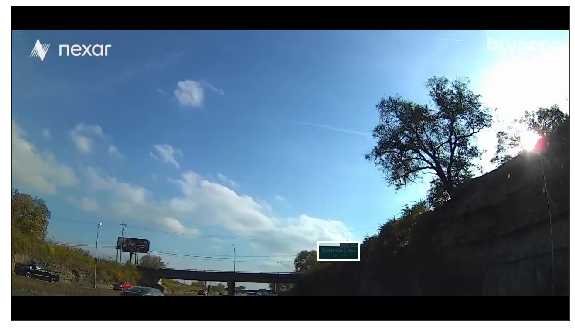

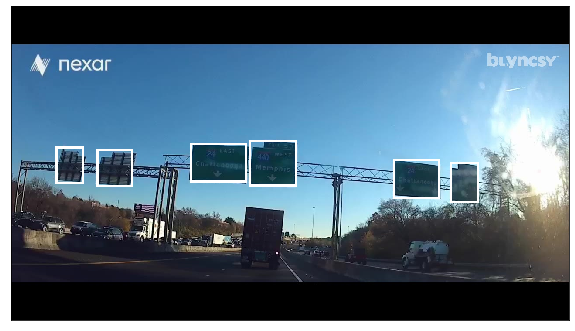

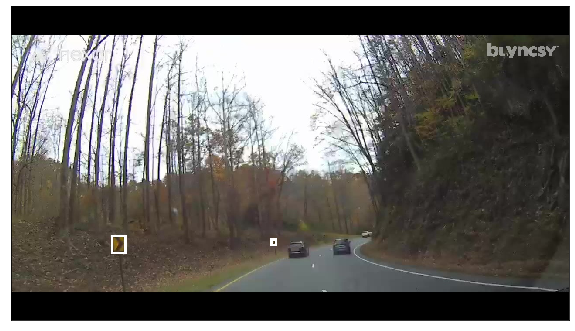

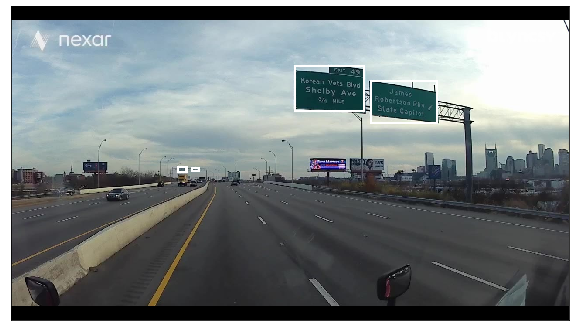

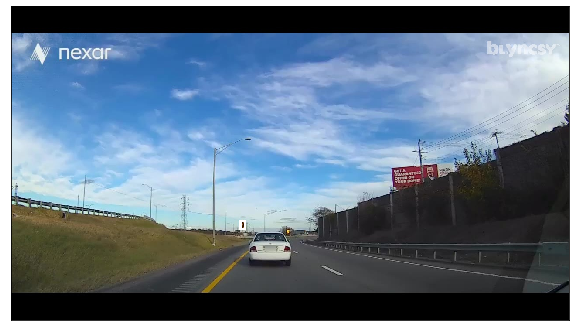

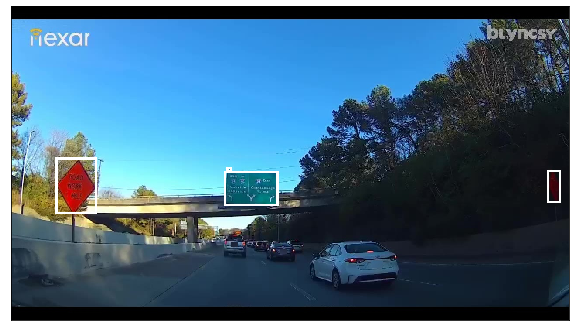

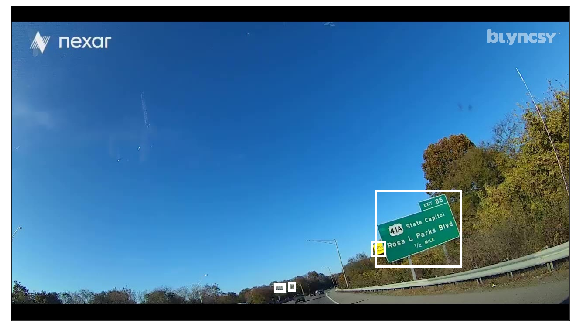

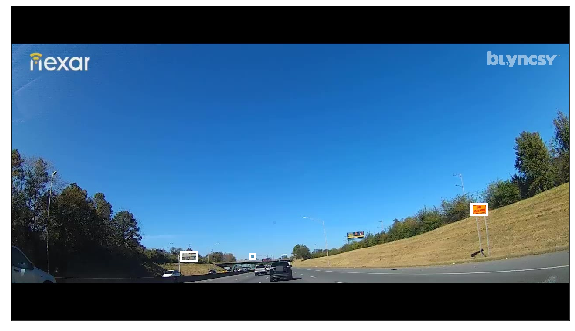

In [28]:
dataset_testing = coco_utils.CocoDetection(training_images_path, anns_file, data_transforms['val'])
dataset_view = coco_utils.CocoDetection(training_images_path, anns_file, data_transforms['view'])

randint = np.random.randint(len(dataset_view)-10)
r = range(randint, randint + 10)
print(f"Showing images from {r}")

# storing predictions
predictions = []


for i in r:
    # pick one image from the test set
    img, _ = dataset_testing[i]
    view, _ = dataset_view[i]
    
    # put the model in evaluation mode
    
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

#     prediction["img"] = 
    score_threshold = 0.8
    boxes = prediction[0]['boxes'][prediction[0]['scores'] > score_threshold]
    scores = prediction[0]['scores'][prediction[0]['scores'] > score_threshold]
    im_int = view.mul(255).byte()#.permute(1, 2, 0).byte()
    show(draw_bounding_boxes(im_int, boxes, width=5))

# Saving your Model
The folowing code demonstrates saving your model to file in two ways:
- saving the entire model allows you to load the model again and continue training
- saving just the model weights, which is more lightweight

In [ ]:
# inf_model_name = f"{model_name}_{desc}_signs_{opt}_{lr_str}_{num_epochs}epochs_bs{batch_size}_state.pth"
# ent_model_name = f"{model_name}_{desc}_signs_{opt}_{lr_str}_{num_epochs}epochs_bs{batch_size}.pth"
# torch.save(model.state_dict(), model_root + inf_model_name)
# torch.save(model, model_root + ent_model_name)

# Testing the model on UDOT images

In [70]:
model = get_instance_segmentation_model(num_classes)
model.to(device)
inf_model_name = "FasterRCNN_frcnn_sceds3gamma2_run2_signs_Adam_0pt0001_30epochs_bs4_state.pth"
model.load_state_dict(torch.load(model_root + inf_model_name))

udotanns = os.path.join("/cs6945share/sign_project", "udot_cvat_edit.json")

batch_size = 1

dataset_valreal = coco_utils.CocoDetection(data_path2, udotanns, data_transforms['val'])
dataloader_valreal = torch.utils.data.DataLoader(dataset_valreal,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=8,
                                                 collate_fn=train.utils.collate_fn)

# evaluate on the test dataset
res2 = engine.evaluate(model, dataloader_valreal, device=device)

types2 = res2.iou_types
stats2 = res2.coco_eval[types2[0]].stats

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Test:  [  0/107]  eta: 0:01:20  model_time: 0.0362 (0.0362)  evaluator_time: 0.0146 (0.0146)  time: 0.7528  data: 0.6990  max mem: 4511
Test:  [ 10/107]  eta: 0:00:10  model_time: 0.0263 (0.0272)  evaluator_time: 0.0088 (0.0094)  time: 0.1047  data: 0.0663  max mem: 4511
Test:  [ 20/107]  eta: 0:00:06  model_time: 0.0253 (0.0262)  evaluator_time: 0.0083 (0.0091)  time: 0.0392  data: 0.0030  max mem: 4511
Test:  [ 30/107]  eta: 0:00:04  model_time: 0.0249 (0.0263)  evaluator_time: 0.0080 (0.0090)  time: 0.0394  data: 0.0031  max mem: 4511
Test:  [ 40/107]  eta: 0:00:03  model_time: 0.0254 (0.0264)  evaluator_time: 0.0080 (0.0089)  time: 0.0408  data: 0.0038  max mem: 4511
Test:  [ 50/107]  eta: 0:00:03  model_time: 0.0250 (0.0261)  evaluator_time: 0.0081 (0.0089)  time: 0.0401  data: 0.0039  max mem: 4511
Test:  [ 60/107]  eta: 0:00:02  model_time: 0.0248 (0.0259)  evaluator_time: 0.0081 (0.0088)  time: 0

In [129]:
combineddf.iloc[0][["AP_small", "AP_medium"]]

AP_small     0.119543
AP_medium    0.532116
Name: 0, dtype: object

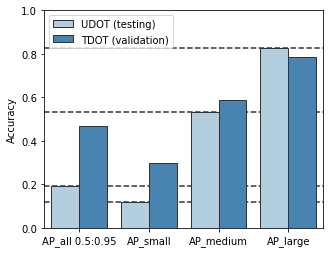

In [143]:
import seaborn as sns

val_tdot = "/home/default/workspace/cs6945share/sign_project/SignDetection/DetectionTraining/train/losses/FasterRCNN_frcnn_sceds3gamma2_run2_Adam_lr0pt0001_bs4_notransforms2_thick00.csv"
tdotdf = pd.read_csv(val_tdot)
tdotdf["dataset"] = "TDOT (validation)"

test_df = pd.DataFrame(data=stats.reshape(1,len(stats)), columns=thick_cols)
params_interest = ["AP_all 0.5:0.95", "AP_small", "AP_medium", "AP_large", "dataset"]
test_df["dataset"] = "UDOT (testing)"

combineddf = pd.concat([test_df, pd.DataFrame(tdotdf.iloc[-1]).T.reset_index(drop=True)], sort=False).reset_index(drop=True)

plt.figure(figsize=(5,4))
plt.hlines([combineddf.iloc[0][["AP_all 0.5:0.95", "AP_small", "AP_medium", "AP_large"]]], -0.5, 4.5, zorder=0,
            colors=(0.2, 0.2, 0.2), linestyles="dashed")
sns.barplot(data=combineddf[params_interest].melt(id_vars=['dataset']),
            x="variable",
            y="value",
            hue="dataset",
            palette="Blues",
            edgecolor=".2")

y1 = np.linspace(0, 1, 6)
plt.yticks(y1)
plt.xlabel("")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("detection_figs/testingacc.png", dpi=300)

plt.show()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Showing images from range(45, 55)


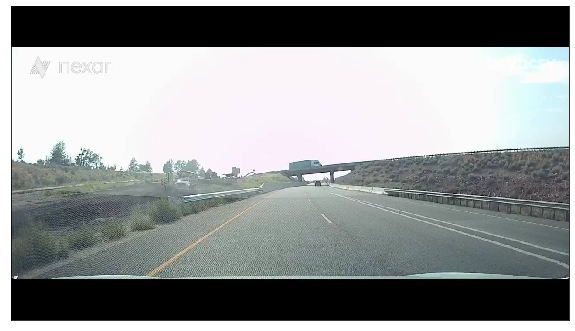

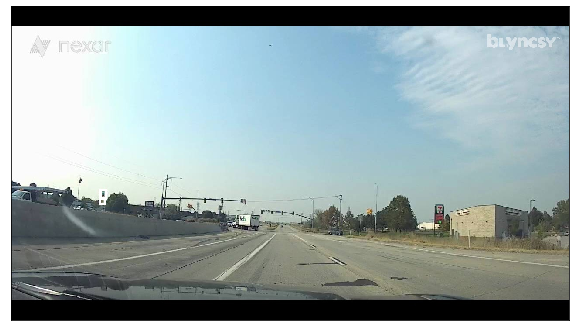

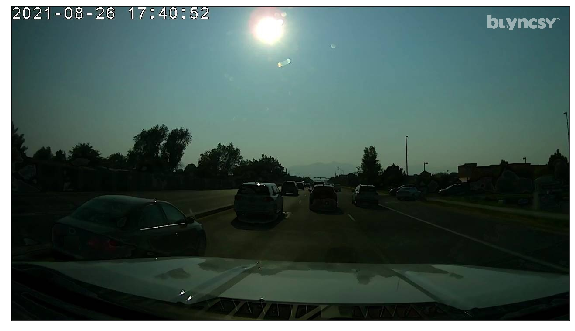

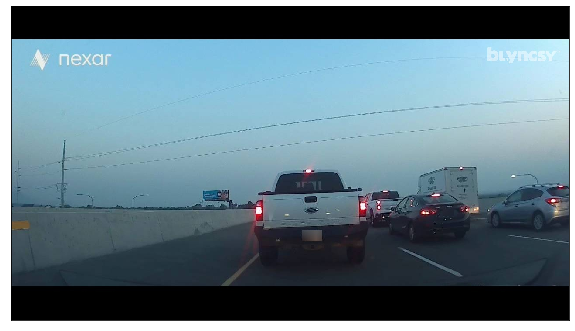

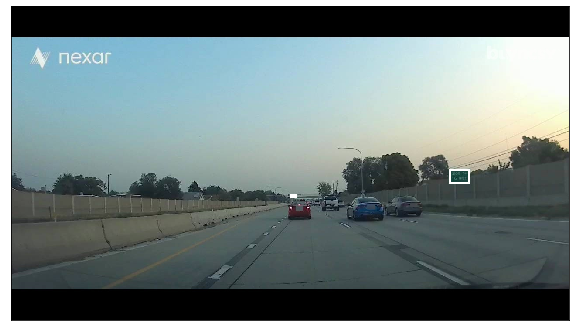

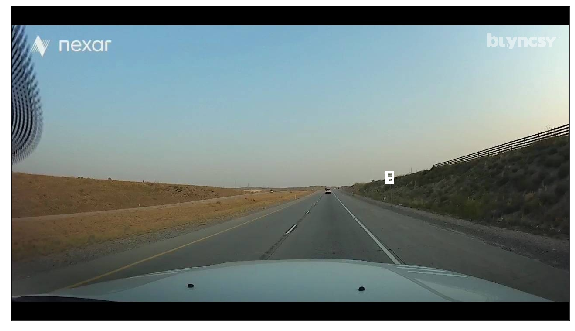

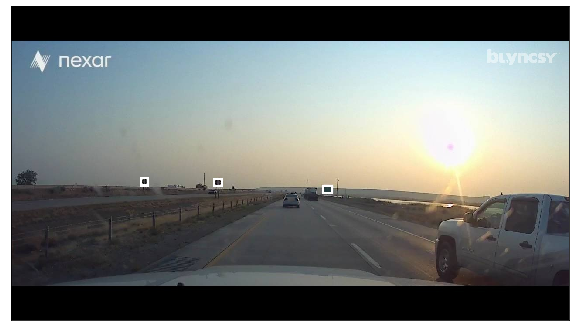

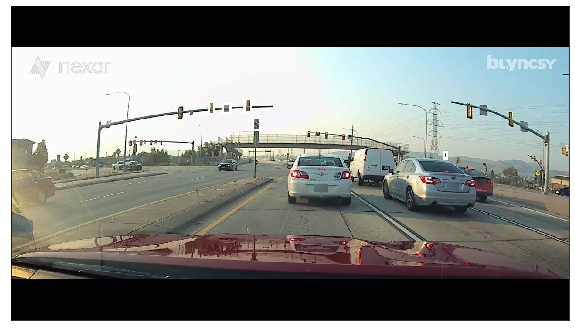

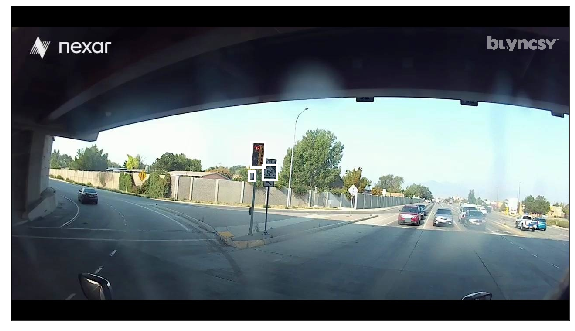

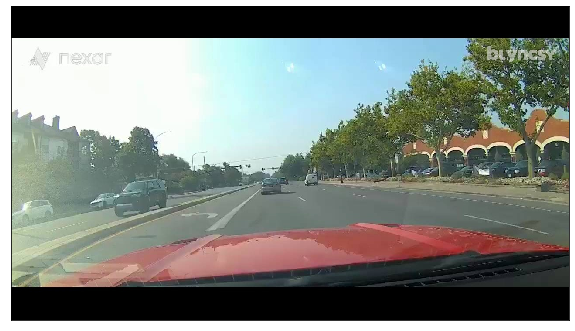

In [43]:
dataset_testing2 = coco_utils.CocoDetection(data_path2, udotanns, data_transforms['val'])
dataset_view2 = coco_utils.CocoDetection(data_path2, udotanns, data_transforms['view'])

randint = np.random.randint(len(dataset_view2)-10)
r = range(randint, randint + 10)
print(f"Showing images from {r}")

# storing predictions
predictions = []


for i in r:
    # pick one image from the test set
    img, _ = dataset_testing2[i]
    view, _ = dataset_view2[i]
    
    # put the model in evaluation mode
    
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

#     prediction["img"] = 
    score_threshold = 0.8
    boxes = prediction[0]['boxes'][prediction[0]['scores'] > score_threshold]
    scores = prediction[0]['scores'][prediction[0]['scores'] > score_threshold]
    im_int = view.mul(255).byte()#.permute(1, 2, 0).byte()
    show(draw_bounding_boxes(im_int, boxes, width=5))